# Introduction
As global temepratures rise the question of how ecosystem respiratory flux will respond to temperature is becoming increasingly important. Though there is a general consensus that ecosystem respiration will increase with temperature there is still uncertainty in the magnitude of this response and what may cause it to vary.

## Measuring temperature sensitvity
If we want to understand this response we need a way to quantify the relationship. One way this is commonly done is through the use of the Boltzmann-Arrhenius equation which describes the exponential-like increase in ecosystem respiration generaly seen with increased temperature: 

\begin{equation}
    R(T) = R_0 e^{-E_R \left( \frac{1}{k T} - \frac{1}{k T_{ref}}\right)}
\end{equation}

This allows us to look at the parameter $E_R$, also known as the activation energy, which describes the thermal sensitvity of the process in question. This $E$ value is equivelant to the slope of this process in the log scale with respect to the temperature term $\frac{1}{k T} - \frac{1}{k T_{ref}}$:

\begin{equation}
    \log(R(T)) = \log(R_0) -E_R \left( \frac{1}{k T} - \frac{1}{k T_{ref}}\right)
\end{equation}

giving an easy way to characterise it from respiration data. 

## Biomass as a driver of temperature sensitvity
As we want to understand what might contribute to this $E$ value we can partition total respiratory carbon flux $R(T)$ into two components,  mass-specific respiratory flux (i.e. the amount of respiratory carbon released per unit biomass) $r(T)$ And biomass $C(T)$ in the system: 

\begin{equation}
    R(T) = r(T) C(T)
\end{equation}
 
Thus to understand how total respriation changes we need to understand how both of these factors combine to determine the sensitvity of total respiration $E_R$. Assuming that they can both be characterised by the Boltzmann-Arrhenius we can write this as:

$$
R = r_0 e^{-E_r \left( \frac{1}{k T} - \frac{1}{k T_{ref}}\right)} 
    C_0 e^{-E_C \left( \frac{1}{k T} - \frac{1}{k T_{ref}}\right)}
  = r_0 C_0 e^{-(E_r + E_C) \left( \frac{1}{k T} - \frac{1}{k T_{ref}}\right) }
$$

which shows that the activation energy of total respiration is equal to the sum of the activation energies of the two components $E_R = E_r + E_C$. 

## How do $r(T)$ and $C(T)$ respond to temperature?
Though the case in which $r(T)$ and $C(T)$ are both described by the Boltzmann-Arrhenius is the simplest, it is probably not the case in reality. Instead it is more likey that $r(T)$ is well described by this relationship but $C(T)$ is not. This is because temperature does not directly drive changes in biomass but instead affects the metabolic processes that affect biomass growth (i.e. the rate at which energy is taken up from the enviroment and allocated to growth). This  creates an inherent time dependence on the effect of temperature on biomass. We only see changes to biomass with temperature as its effects on growth rates are integratd through time. 

Instead we would expect something like:
$$
R(T) = r_0 C_0(t) e^{-(E_r + E_C(T) ) \left( \frac{1}{k T} - \frac{1}{k T_{ref}}\right) }
$$

where there is now a time-dependence to the parameters associated with the biomass thermal sensitvity. 

$$
E_R = E_r + E_C(t)
$$

## Predictions

So how can we use this insight? How do we expect the thermal dependence of biomass to change over time? To do this we can consider a simple model of biomass dynamics at the ecosystem scale. Over an annual scale we expect that temperature should cycle allowing us to characterise it using a sinusoidal funciton:

$$
T(t) = sin(T)
$$

we can also consider a simple logistic model for biomass growth where biomass accumulates according to the growth rate $\mu(T)$ which is limited as biomass approaches carrying capacity $K(T)$(i.e. the maximum biomass the system can sustain). both of these are temperature dependent and follow a Boltzmann-Arrhenius relationship. 

$$
\frac{dC}{dt} = \mu(T)C \left(1 - \frac{C}{K(T)} \right)
$$

Following this basic setup we can use numerical simulations to see how biomass should change over time.

In [4]:
using Pkg
Pkg.activate("../.")
using DifferentialEquations, Plots, GLM, DataFrames, StatsBase

#define structures
struct b_param
    B0::Float64
    E::Float64
end

struct parameters
    μ::b_param
    K::b_param
    r::b_param
end

function  boltz(B::b_param, T)
    B.B0 * exp(B.E * T)
end

#define functions
function parameters(μ0,Eμ,K0,EK,r0,Er)
    parameters(b_param(μ0,Eμ),b_param(K0,EK),b_param(r0,Er))
end

function dC!(dC,C,p,t)
    dC[1] = boltz(p.μ, C[2]) * C[1] * (1 - (C[1] / boltz(p.K, C[2])) )
    dC[2] = 2pi*cos(t*2pi)
end

function get_R(sol,t)
    boltz(sol.prob.p.r,sol(t)[2]) * sol(t)[1]
end

function get_T(sol,t)
   sol(t)[2]
end

Activating environment at `~/Documents/Work/Projects/Working/Bacterial_Interactions/Project.toml`


get_T (generic function with 1 method)

Here we simulate a system where both growth rate and carrying capacity increase with temperature. 

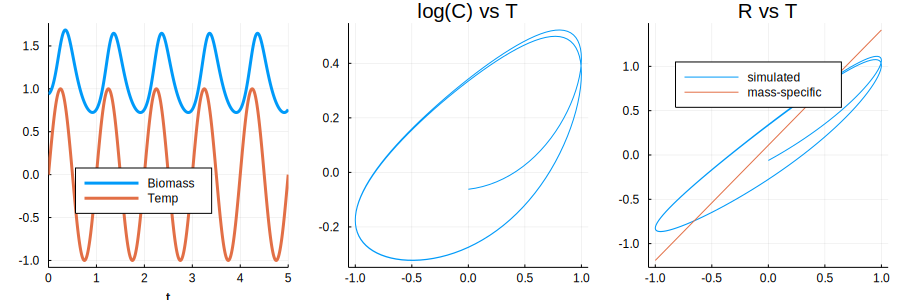

In [20]:
p = parameters(5.0,0.65,
                1.0,0.65, 
                1.0,0.65)

C0 = [0.94,0.0]
tspan = (0.0,5.0)

prob = ODEProblem(dC!,C0,tspan,p)
sol = solve(prob, Tsit5(), reltol=1e-8, abstol=1e-8, saveat = 0.01)

p1 = plot(sol, label = ["Biomass" "Temp"], legend = :bottomleft)

C = hcat(sol.u...)[1,:]
T = hcat(sol.u...)[2,:]
R = get_R.(Ref(sol),sol.t) 

p2 = plot(T,log.(C), title = "log(C) vs T", legend = false)

r = boltz.(Ref(b_param(1.0,0.65 * 2)),T) .* mean(C)
p3 = plot(T,log.(R), title = "R vs T", label = "simulated", legend = :topleft)
plot!(p3,T,log.(r), label = "mass-specific")


plot(p1,p2,p3, layout = (1,3), size = (900,300) )

So we can see here that over time biomass tracks the cycling with temperature with a slight delay (first panel). When we plot this biomass vs temperature this results in an eliptical shape. When we multiply this through by mass-specific repsiration we then get a more skewed ellipsoid. We can work out the slope along this curve to get the $E$ value over time. 

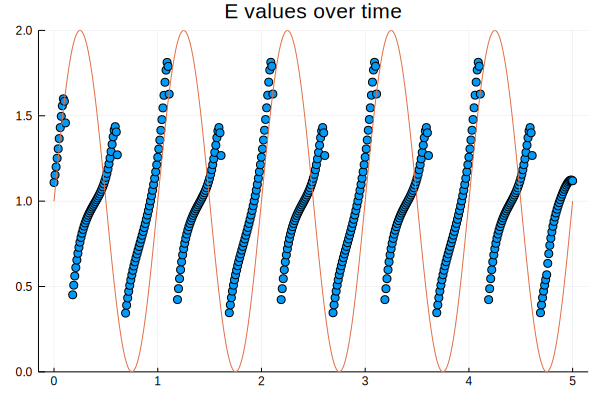

In [24]:
E_vec = Vector{Float64}(undef,length(T))
r2_vec = Vector{Float64}(undef,length(T))

for i  = eachindex(T)
    indx = vcat(collect.( i:(i+25) )...)
    indx[indx .> length(T)] .-= length(T)
    
    data = DataFrame(T = T[indx], R = log.(R[indx]))
    ols = lm(@formula(R ~ T), data)
    E_vec[i] = coef(ols)[2]
    r2_vec[i] = r2(ols)
end
θ = 0.5
scatter(sol.t[r2_vec .> θ], E_vec[r2_vec .> θ], ylim = (0.0,2.0), label = "simulated", title = "E values over time", label = [""])
plot!(sol.t,T .+ 1.0)


Looking at the E values over time we can see that there is a periodic pattern in $E$. These values rise till the temperature peaks (in what would be summer) after which they suddenly fall. They then rise again till the temperature falls to its minimum. 